# Data Preparation:
- Cleaned the user-item interaction data.
- Created a user-to-movie matrix for collaborative filtering.

## Model Training:
- Used cosine similarity with the NearestNeighbors algorithm to find similar items (movies) based on user ratings.

## Movie Recommendations:
- Provided recommendations by identifying similar movies to a specific one using the trained KNN model.

# <center><b><i> Import Libraries

In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
from pprint import pprint
import joblib as jb

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
sns.set_context('talk')

# <center><b><i> Import Data

- Loading u.info -- The number of users, items, and ratings in the u data set.

In [481]:
overall_status = pd.read_csv("../../Data/ml-100k/u.info", names=['Details'])
overall_status

,Details
0,943 users
1,1682 items
2,100000 ratings


- Loading u.data -- The full u data set, 100000 ratings by 943 users on 1682 items.

In [482]:
data_1 = pd.read_csv("../../Data/ml-100k/u.data", names=['user id', 'Movie id', 'Ratings', 'Time stamp'], sep='\t')
data_1.head()

,user id,Movie id,Ratings,Time stamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [483]:
data_1.shape

(100000, 4)

In [484]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   user id     100000 non-null  int64
 1   Movie id    100000 non-null  int64
 2   Ratings     100000 non-null  int64
 3   Time stamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [485]:
cols_name = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
col_name_2 = cols_name.split(" | ")
col_name_2 = [i.capitalize() for i in cols_name.split(" | ")]

In [486]:
item_data = pd.read_csv("../../Data/ml-100k/u.item", header=None, encoding='latin-1', sep="|", names=col_name_2)
item_data.head(4)

,Movie id,Movie title,Release date,Video release date,Imdb url,Unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,Sci-fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [487]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie id            1682 non-null   int64  
 1   Movie title         1682 non-null   object 
 2   Release date        1681 non-null   object 
 3   Video release date  0 non-null      float64
 4   Imdb url            1679 non-null   object 
 5   Unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children            1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-noir           1682 non-null   int64  
 16  Horror

In [488]:
movie_data = item_data[['Movie id', 'Movie title']]
movie_data.head(4)

,Movie id,Movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)


- Looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column

In [489]:
len(item_data.groupby(by=col_name_2[1:])), len(item_data)

(1664, 1682)

- We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset

### <center>Merging required datasets

In [490]:
merged_data = pd.merge(data_1, movie_data, how='inner', on='Movie id')
merged_data.head()

,user id,Movie id,Ratings,Time stamp,Movie title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


<p>A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.</p>

- Example of a multiple rating scenario by an user to a specific movie:

In [491]:
merged_data[(merged_data['Movie title'] == "Chasing Amy (1997)") & (merged_data['user id'] == 894)]

,user id,Movie id,Ratings,Time stamp,Movie title
62716,894,246,4,882404137,Chasing Amy (1997)
90596,894,268,3,879896041,Chasing Amy (1997)


In [492]:
cleaned_data = merged_data.groupby(by=['user id', 'Movie title'], as_index=False).agg({'Ratings':'mean'})
cleaned_data.head()

,user id,Movie title,Ratings
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Exploratory data analysis
- Plot the counts of each rating
- Plot rating frequency of each movie
- Plot the counts of each rating

- We first need to get the counts of each rating from ratings data

In [493]:
num_users = len(cleaned_data['user id'].value_counts())
num_items = len(cleaned_data['Movie title'].value_counts())

print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1664


In [494]:
ratings_count = cleaned_data.groupby('Ratings').size().reset_index(name='Count').set_index('Ratings').sort_index()
ratings_count.head()

,Count
Ratings,
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060


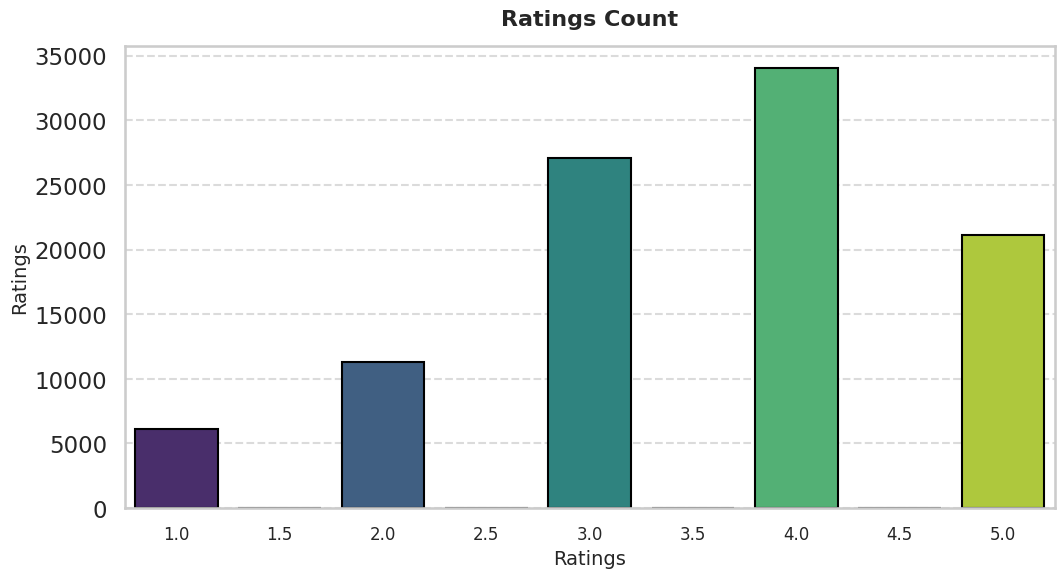

In [495]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ratings_count, x=ratings_count.index, y=ratings_count['Count'], palette='viridis', edgecolor = 'black')

plt.title("Ratings Count", fontsize = 16, fontweight = 'bold', pad=15)
plt.xlabel("Ratings", fontsize = 14)
plt.ylabel('Ratings', fontsize = 14)

plt.xticks(fontsize = 12)
plt.grid(axis='y', linestyle = '--', alpha = .7)

plt.show()

### <b>Insights:</b>
- We can see that number of 1.5, 2.5, 3.5, 4.5 ratings by the users are comparitively negligible.

- Ratings for the movies not seen by a user is by default considered as 0. Lets calculate and add it to the existing dataframe.

In [496]:
zer0_count = (num_items * num_users) - cleaned_data.shape[0]
zer0_count

1469459

In [497]:
zero_count_df = pd.DataFrame({'Count': [zer0_count]}, index=[0.0])

In [498]:
ratings_count = pd.concat([ratings_count, zero_count_df]).sort_index()

In [499]:
ratings_count['Log Count'] = np.log(ratings_count['Count'])
ratings_count.head(3)

,Count,Log Count
0.0,1469459,14.200405
1.0,6083,8.713253
1.5,3,1.098612


In [500]:
ratings_count = ratings_count.reset_index(names=['Rating Score'])
ratings_count

,Rating Score,Count,Log Count
0,0.0,1469459,14.200405
1,1.0,6083,8.713253
2,1.5,3,1.098612
3,2.0,11334,9.335562
4,2.5,6,1.791759
5,3.0,27060,10.205812
6,3.5,19,2.944439
7,4.0,34042,10.435350
8,4.5,16,2.772589
9,5.0,21130,9.958449


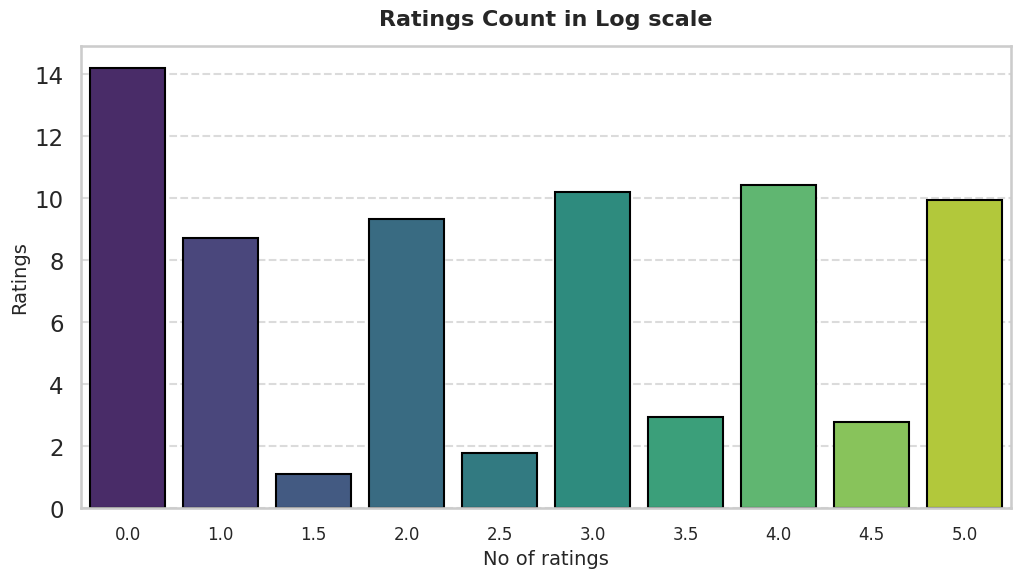

In [501]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ratings_count, x=ratings_count['Rating Score'], y=ratings_count['Log Count'], palette='viridis', edgecolor = 'black')

plt.title("Ratings Count in Log scale", fontsize = 16, fontweight = 'bold', pad=15)
plt.xlabel("No of ratings", fontsize = 14)
plt.ylabel('Ratings', fontsize = 14)

plt.xticks(fontsize = 12)
plt.grid(axis='y', linestyle = '--', alpha = .7)

plt.show()

### <b>Insights:</b>:
- We have already observed from the before bar plot that ratings 3 and 4 are given in more numbers by the users. Even the above graph suggests the same.

In [502]:
cleaned_data.head()

,user id,Movie title,Ratings
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


### Plot rating frequency of all movies

In [503]:
movie_count = cleaned_data.groupby('Movie title').size().reset_index(name='Movie Count').sort_values(by='Movie Count', ascending=False).head(8)
movie_count

,Movie title,Movie Count
1398,Star Wars (1977),583
333,Contact (1997),509
498,Fargo (1996),508
1234,Return of the Jedi (1983),507
860,Liar Liar (1997),485
460,"English Patient, The (1996)",481
1284,Scream (1996),478
1523,Toy Story (1995),452


### Top 8 Movies

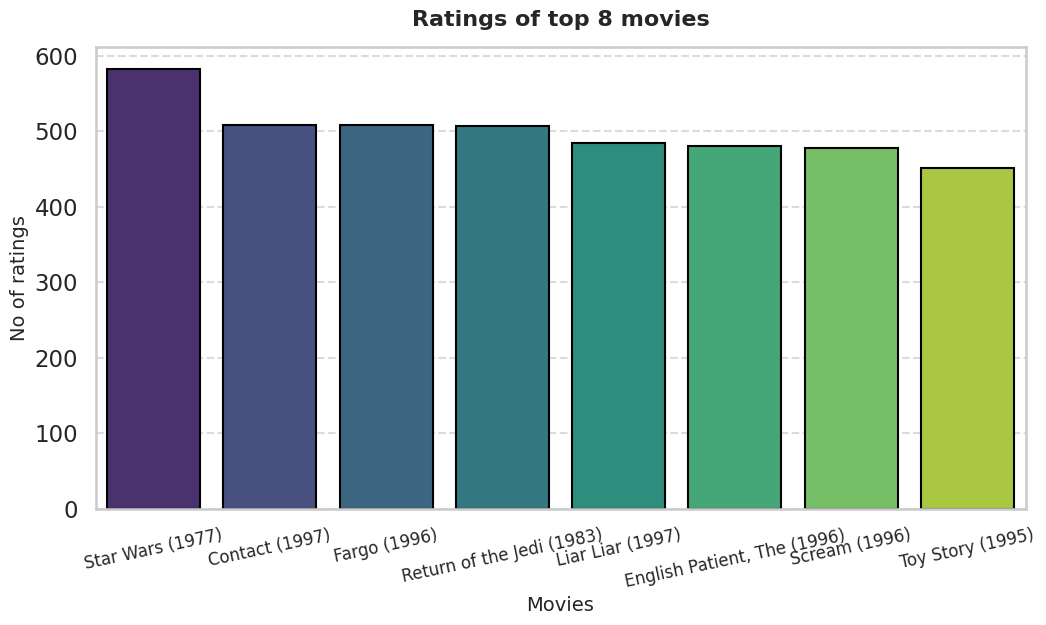

In [504]:
plt.figure(figsize=(12, 6))

sns.barplot(data=movie_count.head(10), x=movie_count['Movie title'], y=movie_count['Movie Count'], palette='viridis', edgecolor = 'black')

plt.title("Ratings of top 8 movies", fontsize = 16, fontweight = 'bold', pad=15)
plt.xlabel("Movies", fontsize = 14)
plt.ylabel('No of ratings', fontsize = 14)

plt.xticks(fontsize = 12, rotation = 12)
plt.grid(axis='y', linestyle = '--', alpha = .7)

plt.show()

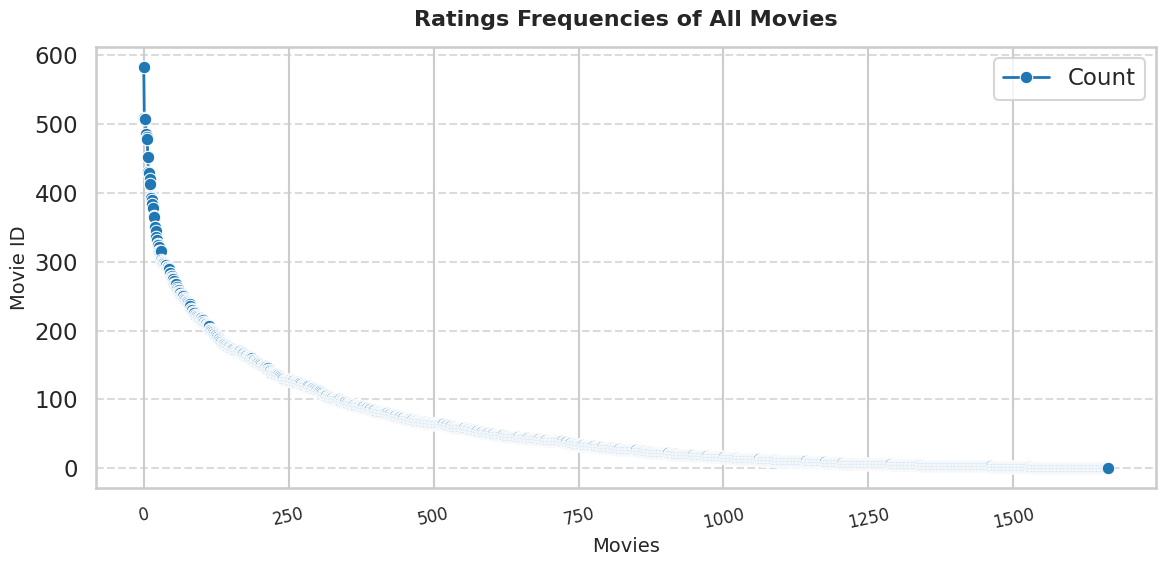

In [505]:
movie_count = cleaned_data.groupby('Movie title').size().reset_index(name='Count').set_index("Movie title").sort_values(by='Count', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 6))

sns.lineplot(data=movie_count, marker='o', color='purple', linewidth=2)

plt.title("Ratings Frequencies of All Movies", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Movies", fontsize=14)
plt.ylabel("Movie ID", fontsize=14)

plt.xticks(fontsize=12, rotation=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<p> As the size of MovieLens dataset picked for this project is small. There is no need of removing rarely rated movies or users who has given rating for fewer movies.

Also because the dataset considered is small, we do not see the long-tail property which will be the scenario with the distribution of ratings.

If the dataset is larger, then (this can be referred when we do similar kind of tasks with a larger dataset, just for future reference)

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.</p>

### Training KNN model to build item-based collaborative Recommender System:

<b>Reshaping the dataframe</b>

<p>We need to transform (reshape in this case) the data in such a way that each row of the dataframe represents a movie and each column represents a different user. So we want the data to be [movies, users] array if movie is the subject where similar movies must be found and [users, movies] array for reverse.

To reshape the dataframe, we will pivot the dataframe to the wide format with movies as rows and users as columns. As we know that not all users watch all the movies, we can expect a lot of missing values. We will have to fill those missing observations with 0s since we are going to perform linear algebra operations (calculating distances between vectors).

Finally, we transform the values of the dataframe into a scipy sparse matrix for most efficient calculations.

This dataframe is then fed into a KNN model.</p>

### Movie Recommendation using KNN with Input as User id, Number of similar users should the model pick and Number of movies you want to get recommended:

1. Reshaping model in such a way that each user has n-dimensional rating space where n is total number of movies

<p>We will train the KNN model inorder to find the closely matching similar users to the user we give as input and we recommend the top movies which would interest the input user.</p>

In [506]:
user_to_movie_pvt = cleaned_data.pivot(index='user id', columns='Movie title', values='Ratings').fillna(0)
user_to_movie_pvt.head(5)

Movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [507]:
user_to_movie_pvt_sparse = csr_matrix(user_to_movie_pvt.values)
user_to_movie_pvt_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 99693 stored elements and shape (943, 1664)>

In [508]:
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(user_to_movie_pvt_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [509]:
def get_similar_users(user, n = 5):
  knn_input = np.asarray([user_to_movie_pvt.values[user-1]])
  
  distances, indices = model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]

<p> Specify User id and Number of similar users we want to consider here</p>

In [510]:
user_id = 778
print("Few of movies seen by user: ")
pprint(list(cleaned_data[cleaned_data['user id'] == user_id]['Movie title'])[:10])
similar_user_lst, distance_lst = get_similar_users(user_id)

Few of movies seen by user: 
['Amityville Horror, The (1979)',
 'Angels in the Outfield (1994)',
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Blues Brothers, The (1980)',
 'Chasing Amy (1997)',
 'Clerks (1994)']
Top 5 users who are very much similar to the User- 778 are: 
 
1 . User: 124 separated by distance of 0.4586649429539592
2 . User: 933 separated by distance of 0.5581959868865324
3 . User: 56 separated by distance of 0.5858413112292744
4 . User: 738 separated by distance of 0.5916272517988691
5 . User: 653 separated by distance of 0.5991479757406326


<p>With the help of the KNN model built, we could get desired number of top similar users.

Now we will have to pick the top movies to recommend.

One way would be by taking the average of the existing ratings given by the similar users and picking the top 10 or 15 movies to recommend to our current user.

But I feel recommendation would be more effective if we define weights to ratings by each similar user based on the thier distance from the input user. Defining these weights would give us the accurate recommendations by eliminating the chance of decision manipulation by the users who are relatively very far from the input user.</p>

In [511]:
similar_user_lst, distance_lst

(array([124, 933,  56, 738, 653]),
 array([0.45866494, 0.55819599, 0.58584131, 0.59162725, 0.59914798]))

In [512]:
weightage_lst = distance_lst/np.sum(distance_lst)
weightage_lst

array([0.16419139, 0.19982119, 0.20971757, 0.2117888 , 0.21448105])

In [513]:
movie_ratings_sim_users = user_to_movie_pvt.values[similar_user_lst]
movie_ratings_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [514]:
movies_lst = user_to_movie_pvt.columns
movies_lst

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)',
       '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Yankee Zulu (1994)', 'Year of the Horse (1997)', 'You So Crazy (1994)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)',
       'Zeus and Roxanne (1997)', 'unknown',
       'Á köldum klaka (Cold Fever) (1994)'],
      dtype='object', name='Movie title', length=1664)

In [515]:
print("Weightage list shape:", len(weightage_lst))
print("mov_rtngs_sim_users shape:", movie_ratings_sim_users.shape)
print("Number of movies:", len(movies_lst))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


In [516]:
weightage_lst[:,np.newaxis] + np.zeros(len(movies_lst))

array([[0.16419139, 0.16419139, 0.16419139, ..., 0.16419139, 0.16419139,
        0.16419139],
       [0.19982119, 0.19982119, 0.19982119, ..., 0.19982119, 0.19982119,
        0.19982119],
       [0.20971757, 0.20971757, 0.20971757, ..., 0.20971757, 0.20971757,
        0.20971757],
       [0.2117888 , 0.2117888 , 0.2117888 , ..., 0.2117888 , 0.2117888 ,
        0.2117888 ],
       [0.21448105, 0.21448105, 0.21448105, ..., 0.21448105, 0.21448105,
        0.21448105]])

<p>Broadcasting weightage matrix to similar user rating matrix. so that it gets compatible for matrix operations

In [517]:
weightage_lst = weightage_lst[:,np.newaxis] + np.zeros(len(movies_lst))
weightage_lst.shape

(5, 1664)

In [518]:
new_rating_matrix = weightage_lst*movie_ratings_sim_users
mean_rating_lst = new_rating_matrix.sum(axis = 0)
mean_rating_lst

array([0.        , 0.        , 1.02879509, ..., 0.        , 0.        ,
       0.        ])

In [519]:
def recommend_movies(n):
    n = min(len(mean_rating_lst), n)
    
    pprint(list(movies_lst[np.argsort(mean_rating_lst)[::-1][:n]]))

In [520]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Star Wars (1977)',
 'Terminator, The (1984)',
 "Schindler's List (1993)",
 'Fugitive, The (1993)',
 'Forrest Gump (1994)',
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Pulp Fiction (1994)',
 'Die Hard (1988)',
 'Monty Python and the Holy Grail (1974)']


It had been observed that, this recommendation system built can be made more efficient as it has few drawbacks.

#### Drawbacks:

1. But this recommendation system has a drawback, it also recommends movies which are already seen by the given input User.

2. And also there is a possibility of recommending the movies which are not at all seen by any of the similar users.

Above drawbacks are addressed and a new recommender system with modification is built

Below function is defined to remove the movies which are already seen the current user and not at all seen by any of the similar users.



In [521]:
def filtered_movie_recommendations(n, user_id):
  
  first_zero_index = np.where(mean_rating_lst == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_lst)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(cleaned_data[cleaned_data['user id'] == user_id]['Movie title'])
  filtered_movie_list = list(movies_lst[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)


In [522]:
filtered_movie_recommendations(10, 778)

['Star Wars (1977)',
 "Schindler's List (1993)",
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Return of the Jedi (1983)',
 'Fargo (1996)',
 'Dances with Wolves (1990)',
 'Toy Story (1995)',
 'Braveheart (1995)',
 'Star Trek: First Contact (1996)']


Coding up all of the above individual cells into a function.

Giving Input as <b> User id, Number of similar Users to be considered, Number of top movie we want to recommend

In [523]:
def recommender_system(user_id, n_similar_usrs, n):
    
    print("Movie seen by the User:")
    pprint(list(cleaned_data[cleaned_data['user id'] == user_id]['Movie title']))
    print("")
    
    
    def get_similar_users(user, n = 5):
        knn_input = np.asarray([user_to_movie_pvt.values[user-1]])  #.reshape(1,-1)
        
        distances, indices = model.kneighbors(knn_input, n_neighbors=n+1)
        
        print("Top",n,"users who are very much similar to the User-",user, "are: ")
        print(" ")
        for i in range(1,len(distances[0])):
            print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
        return indices.flatten()[1:] + 1, distances.flatten()[1:]

    def filtered_movie_recommendations(n = 10):
  
        first_zero_index = np.where(mean_rating_lst == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_lst)[::-1]
        sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        n = min(len(sortd_index),n)
        movies_watched = list(cleaned_data[cleaned_data['user id'] == user_id]['Movie title'])
        filtered_movie_list = list(movies_lst[sortd_index])
        count = 0
        final_movie_list = []
        for i in filtered_movie_list:
            if i not in movies_watched:
                count+=1
                final_movie_list.append(i)
            if count == n:
                break
        if count == 0:
            print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
        else:
            pprint(final_movie_list)


    similar_user_lst, distance_lst = get_similar_users(user_id, n_similar_usrs)
    weightage_lst = distance_lst/np.sum(distance_lst)
    movie_ratings_sim_users = user_to_movie_pvt.values[similar_user_lst]
    movies_lst = user_to_movie_pvt.columns
    weightage_lst = weightage_lst[:,np.newaxis] + np.zeros(len(movies_lst))
    new_rating_matrix = weightage_lst*movie_ratings_sim_users
    mean_rating_lst = new_rating_matrix.sum(axis = 0)
    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    filtered_movie_recommendations(n)

In [524]:
print("Enter User ID: ")
user_id = int(input())

print("Number of Similar user to be considered ")
sim_user = int(input())

print("Enter number of movies to be recommended ")
n_movies = int(input())

recommender_system(user_id, sim_user, n_movies)

Enter User ID: 
Number of Similar user to be considered 
Enter number of movies to be recommended 
Movie seen by the User:
['2001: A Space Odyssey (1968)',
 'Abyss, The (1989)',
 'Aladdin (1992)',
 'Aladdin and the King of Thieves (1996)',
 'Amadeus (1984)',
 'American Werewolf in London, An (1981)',
 "Amityville 1992: It's About Time (1992)",
 'Amityville 3-D (1983)',
 'Amityville Curse, The (1990)',
 'Amityville Horror, The (1979)',
 'Amityville II: The Possession (1982)',
 'Amityville: A New Generation (1993)',
 'Annie Hall (1977)',
 'Apollo 13 (1995)',
 'Army of Darkness (1993)',
 'Audrey Rose (1977)',
 'Bad Moon (1996)',
 'Beauty and the Beast (1991)',
 'Believers, The (1987)',
 'Big Blue, The (Grand bleu, Le) (1988)',
 'Big Sleep, The (1946)',
 'Birds, The (1963)',
 'Blade Runner (1982)',
 'Blob, The (1958)',
 'Body Snatchers (1993)',
 "Bram Stoker's Dracula (1992)",
 'Braveheart (1995)',
 'Candyman (1992)',
 'Candyman: Farewell to the Flesh (1995)',
 'Cape Fear (1991)',
 'Casabl

## Movie Recommendation using KNN with Input as Movie Name and Number of movies you want to get recommended:

In [525]:
movie_to_user_pvt = cleaned_data.pivot(index='Movie title', columns='user id', values='Ratings').fillna(0)
movie_to_user_pvt.head()

user id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
Movie title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),5.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (1997),0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.

We will train the KNN model inorder to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.

In [545]:
movie_to_user_pvt.to_csv("movie_to_user_pivot.csv")

In [526]:
movie_to_user_pvt_sparse = csr_matrix(movie_to_user_pvt.values)
movie_to_user_pvt_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 99693 stored elements and shape (1664, 943)>

- Extracting movie names into a list:

In [527]:
movies_lst = list(movie_to_user_pvt.index)
movies_lst[:6]

["'Til There Was You (1997)",
 '1-900 (1994)',
 '101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '187 (1997)',
 '2 Days in the Valley (1996)']

- Creating a dictionary with movie name as key and its index from the list as value:

In [528]:
movie_dict = {movie: idx for idx, movie in enumerate(movies_lst)}

In [532]:
case_insensitive_movies_list = [i.lower() for i in movies_lst]

In [533]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_pvt_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# jb.dump(knn_movie_model, "item_item_knn_model.joblib")

['item_item_knn_model.joblib']

In [534]:
def get_similar_movies(movie, n = 5):
  
  idx = movie_dict[movie]
  
  knn_input = np.asarray([movie_to_user_pvt.values[idx]])
  
  n = min(len(movies_lst)-1, n)
  distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movies_lst[indices[0][i]])

In [535]:
get_similar_movies("101 Dalmatians (1996)", 10)

Top 10 users who are very much similar to the User- 101 Dalmatians (1996) are: 
 
Jack (1996)
Twister (1996)
Willy Wonka and the Chocolate Factory (1971)
Independence Day (ID4) (1996)
Toy Story (1995)
Father of the Bride Part II (1995)
Hunchback of Notre Dame, The (1996)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Jungle Book, The (1994)
